In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sys import getsizeof
from time import time

def mb_size_str(obj: object, name: str):
    return f"{name} size is {round(getsizeof(obj) / pow(1024, 2), 2)}MB"

import gensim
import logging

logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

train_file = "train.csv"
train_df = pd.read_csv(train_file)
INPUT_DATASET_SIZE = train_df.shape[0]
b_time = time()

## Preproc

In [2]:
cfg = {
    'TF_IDF': True,
    'LEMMATIZE': False,
    'DO_STEMMING': False,
    'STOPLIST': True,
    'LOWFREQ_FILTER': False,
    'LOWFREQ_TRESHOLD': 0,
    'TEST_RATIO': 0.2, # ratio of train samples that will go as test ones
    'MODEL': "6 Gensim Continuous Skipgram",
}

In [3]:
from tqdm import tqdm

# # # # # # # # # # # # # # # # # # # 
#           Preprocessing           #
# # # # # # # # # # # # # # # # # # # 

import src.preprocessing as prep

freq_dict = {}
token_amount_counter = [0]

print("Preprocessing...")
for row_id in tqdm(range(INPUT_DATASET_SIZE)):
    text = train_df.loc[row_id, "text"]
    train_df.loc[row_id, "text"] = prep.preprocess(
        text, cfg, freq_dict, token_amount_counter
    )

if cfg['LOWFREQ_FILTER']:
    forms_to_remove = set(w for (w, freq) in freq_dict.items() if freq <= cfg['LOWFREQ_TRESHOLD'])
    new_token_amount_counter = [0]
    print(f"Removing low freq tokens (freq <= {cfg['LOWFREQ_TRESHOLD']})...")
    print(f"Total forms: {len(freq_dict.items())}")
    print(f"Total forms to be removed {len(forms_to_remove)}")
    for row_id in tqdm(range(INPUT_DATASET_SIZE)):
        text = train_df.loc[row_id, "text"]
        train_df.loc[row_id, "text"] = prep.remove_lowfreq(text, forms_to_remove, new_token_amount_counter)
    shrink_percent = round(100 * (token_amount_counter[0] - new_token_amount_counter[0]) / token_amount_counter[0], 2)
    print(f"Total token amount:\nold {token_amount_counter[0]}\nnew {new_token_amount_counter[0]}\n{shrink_percent}% total less")

train_df.to_csv(f"train_cleaned.csv", index=False)

Preprocessing...


100%|██████████| 25000/25000 [00:12<00:00, 1950.38it/s]


### TfIdf

In [17]:
from src.tfidf import get_matrix
tfidf, matrix = get_matrix(train_df['text'].to_list()) if cfg['TF_IDF'] else (None, None)

INFO : TF-IDF matrix...
INFO : Матрица на 25000 документов и 144380 термов


### Word Vectors

In [5]:
# LOAD THE MODEL
from nltk.tokenize import word_tokenize
w2v_file = f"{cfg['MODEL']}/model.bin"
model: gensim.models.keyedvectors.KeyedVectors = gensim.models.KeyedVectors.load_word2vec_format(w2v_file, binary=True)
VECTOR_SIZE = model.vector_size

INFO : loading projection weights from 6 Gensim Continuous Skipgram/model.bin
INFO : KeyedVectors lifecycle event {'msg': 'loaded (302866, 300) matrix of type float32 from 6 Gensim Continuous Skipgram/model.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-02-14T15:38:59.523633', 'gensim': '4.3.0', 'python': '3.10.9 (main, Dec 19 2022, 17:35:49) [GCC 12.2.0]', 'platform': 'Linux-6.1.11-1-MANJARO-x86_64-with-glibc2.37', 'event': 'load_word2vec_format'}


In [6]:
from src.vectorizers import get_tfidf_vector

def text_vector(text: str, text_id: int) -> np.ndarray:
    """Compute the normalized weighted mean w2v vector for a given text"""

    tokens = [token for token in word_tokenize(text) if token in model]
    # Compute the word2vec vectors for each word in the text
    vectors = [model.get_vector(tkn) for tkn in tokens]
    if cfg['TF_IDF']:
        # Compute the tf-idf values for each word in the text.
        tfidf_vals = get_tfidf_vector(tokens, text_id, matrix, tfidf)
        # Compute the weighted vectors by multiplying the word2vec vectors by the tf-idf values
        weighted_vecs = np.array([vec * factor for vec, factor in zip(vectors, tfidf_vals)])
    else:
        weighted_vecs = np.array(vectors)

    text_sum_vec = np.sum(weighted_vecs, axis=0)
    norm_vec = text_sum_vec / np.linalg.norm(text_sum_vec)
    
    return norm_vec

review_vectors = np.empty((INPUT_DATASET_SIZE, VECTOR_SIZE), dtype=float)
print(review_vectors.shape)
print("Calculating mean review vectors...")
for row_id in tqdm(range(INPUT_DATASET_SIZE)):
    review_vectors[row_id] = text_vector(train_df.loc[row_id, "text"], row_id)

(25000, 300)
Calculating mean review vectors...


100%|██████████| 25000/25000 [02:16<00:00, 182.58it/s]


In [7]:
import src.vectorizers as vecs  
conc_matrix = vecs.concat_w2v(review_vectors, matrix)

100%|██████████| 25000/25000 [03:44<00:00, 111.43it/s]


In [8]:
# trying not to run out of memory on my potatoe (╥﹏╥)
print(getsizeof(review_vectors) / pow(1024, 2), "MB")
#model = None

57.2205810546875 MB


## Train

In [9]:
answers = train_df['answer'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    conc_matrix,
    answers,
    test_size=cfg['TEST_RATIO']
)

print(f"""
    Total answers: {answers.shape[0]}
    Total reviews: {conc_matrix.shape[0]}
    Review vector size: {conc_matrix.shape[1]}
    Answers splitted: {y_train.shape[0]} / {y_test.shape[0]}
    Input splitted: {X_train.shape[0]} / {X_test.shape[0]}
    """)


    Total answers: 25000
    Total reviews: 25000
    Review vector size: 144680
    Answers splitted: 20000 / 5000
    Input splitted: 20000 / 5000
    


In [14]:
from sklearn.linear_model import LogisticRegression
from pprint import pprint

reg : LogisticRegression = LogisticRegression(max_iter=10_000).fit(X_train, y_train)

diff = time() - b_time

results = {}
results.update(cfg)
print(f"""
    Score on
      - train  data : {reg.score(X_train, y_train)}
      - test   data : {reg.score(X_test, y_test)}
    Test/train size : {cfg['TEST_RATIO']}
    Total time      : {"{:.0f}m {:.0f}s".format(*divmod(diff, 60))}
""")


    Score on
      - train  data : 0.92635
      - test   data : 0.8714
    Test/train size : 0.2
    Total time      : 12m 16s



(124680.0, 144680.0)

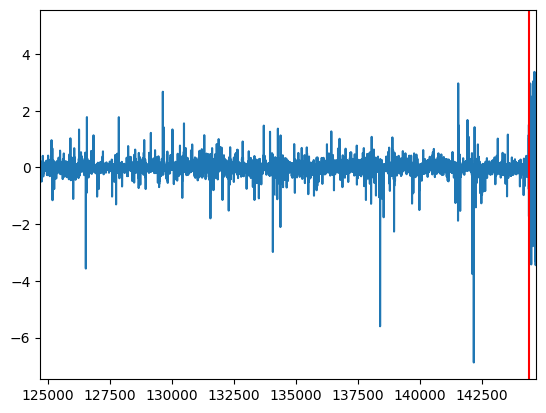

In [32]:
import matplotlib.pyplot as plt

plt.plot(reg.coef_[0])
plt.axvline(len(reg.coef_[0]) - 300, color='r')
plt.xlim([len(reg.coef_[0]) - 20000, len(reg.coef_[0])])

```
      - train  data : 0.83735
      - test   data : 0.8364
    Test/train size : 0.2

    # + tfidf
      - train  data : 0.8083555555555556
      - test   data : 0.7952
    Test/train size : 0.1

    # freq_threshold: 100
    Score on
      - train  data : 0.8035
      - test   data : 0.8026
    Test/train size : 0.2
```

#  Testing

In [11]:
def get_vector(text: str) -> np.ndarray:
    tokens = [token for token in word_tokenize(text) if token in model]
    # Compute the word2vec vectors for each word in the text
    vectors = np.array([model.get_vector(tkn) for tkn in tokens])
    sum_vector = np.sum(vectors, axis=0)
    norm_vector = sum_vector / np.linalg.norm(sum_vector)
    return norm_vector

test_file = "test.csv"
test_df = pd.read_csv(test_file)
TEST_DATASET_SIZE = test_df.shape[0]

# # # # # # # # # # # # # # # # # # # 
#             Processing            #
# # # # # # # # # # # # # # # # # # # 
print("Processing...")
result = test_df[["id"]].copy()
for row_id in tqdm(range(TEST_DATASET_SIZE)):
    text = test_df.loc[row_id, "text"]
    test_df.loc[row_id, "text"] = prep.preprocess(
        text, cfg, freq_dict, token_amount_counter
    )
    result.loc[row_id, "answer"] = int(reg.predict([get_vector(text)])[0])
test_df.to_csv(f"test_cleaned.csv", index=False)
result["answer"] = result["answer"].astype(int)
result.to_csv(f"result.csv", index=False)

Processing...


  0%|          | 0/25000 [00:00<?, ?it/s]


ValueError: X has 300 features, but LogisticRegression is expecting 144680 features as input.